In [1]:
%matplotlib inline

In [2]:
from subprocess import run
import os
from matplotlib import pyplot, patches, collections
from cartopy import crs, feature
from xarray import open_dataset
import numpy as np
from matplotlib.tri import Triangulation

In [3]:
os.makedirs('meshes', exist_ok=True)
res = 30
run(f'GenerateCSMesh --alt --res {res} --file meshes/ne{res}.g'.split(' '), capture_output=True)

CompletedProcess(args=['GenerateCSMesh', '--alt', '--res', '30', '--file', 'meshes/ne30.g'], returncode=0, stdout=b'Parameters:\n  --res <integer> [30] \n  --file <string> ["meshes/ne30.g"] \n  --out_format <string> ["Netcdf4"] \n  --alt <bool> [true] \n=========================================================\n..Generating mesh with resolution [30]\n..Writing mesh to file [meshes/ne30.g] \nNodes per element\n..Block 1 (4 nodes): 5400\n..Mesh generator exited successfully\n=========================================================\n', stderr=b'')

In [4]:
ne30 = open_dataset(f'meshes/ne{res}.g')

In [5]:
# Func to plot the exodus files
def get_lines(ds,ax):
    x = ds['coord'][0,:].squeeze()
    y = ds['coord'][1,:].squeeze()
    z = ds['coord'][2,:].squeeze()
    lon = np.arctan2(y, x) * 180.0 / np.pi
    lat = np.arcsin(z) * 180.0 / np.pi
    corner_indices = ds['connect1']
    xx = lon[corner_indices[:,:] - 1]
    yy = lat[corner_indices[:,:] - 1]
    lines = [[[xx[i,j], yy[i,j]] for j in range(xx.shape[1])] for i in range(xx.shape[0])]
    line_collection = collections.LineCollection(lines, transform=crs.Geodetic(),colors='k',linewidth=0.1)
    ax.add_collection(line_collection)

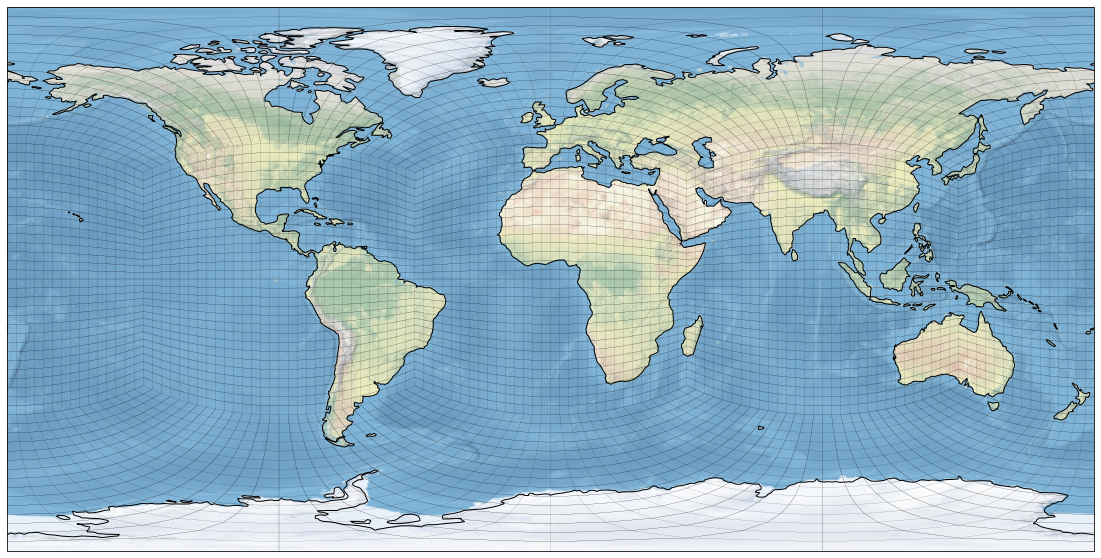

In [6]:
figure = pyplot.figure(figsize=(20, 10))
#ax = figure.add_subplot(111, projection=crs.Orthographic(central_latitude=50,central_longitude=-90))
ax = figure.add_subplot(111, projection=crs.PlateCarree())
ax.stock_img()
ax.coastlines()
lines=get_lines(ne30,ax)

In [7]:
# Draw a polygon around CONUS: https://gmd.copernicus.org/articles/12/2679/2019/#&gid=1&pid=1
lat_bounds = ( 22, 50)
lon_bounds = (-64, -126)
vertices = [(lon_bounds[0], lat_bounds[0]), 
            (lon_bounds[1], lat_bounds[0]), 
            (lon_bounds[1], lat_bounds[1]),
            (lon_bounds[0], lat_bounds[1])]

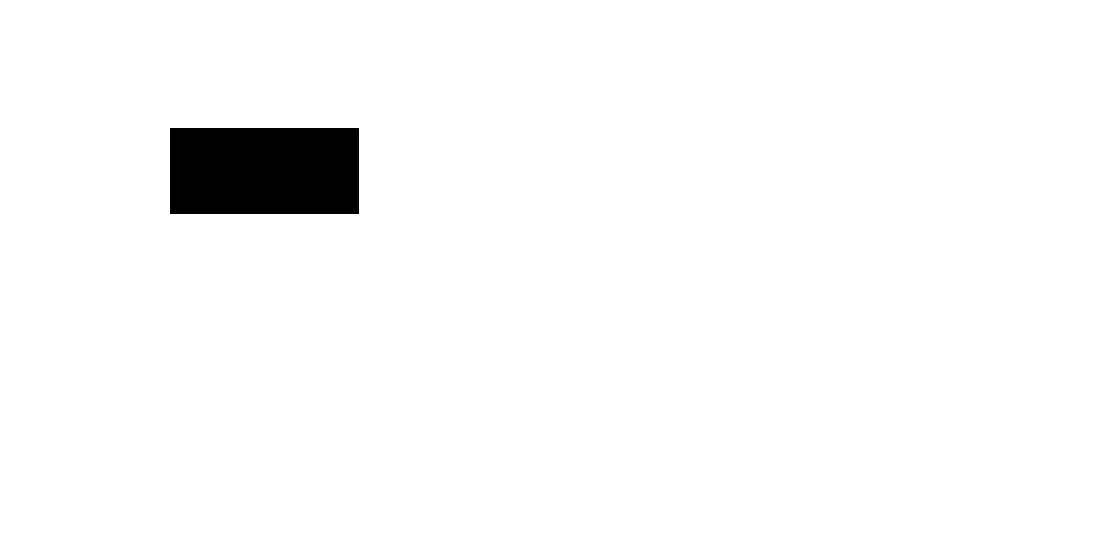

In [8]:
figure3 = pyplot.figure(figsize=(20, 10))
ax3 = figure3.add_subplot(111, projection=crs.PlateCarree())
ax3.set_global()
polygon = patches.Polygon(vertices, closed=True, color='black', transform=crs.PlateCarree())
ax3.add_patch(polygon)
ax3.axis('off')
figure3.savefig('meshes/refinement_patch.png', bbox_inches='tight', pad_inches=0.0,dpi=350)

In [10]:
# Create a refined mesh with squadgen
run(f'/mnt/d/Work/squadgen/squadgen/SQuadGen --resolution {res} --refine_file meshes/refinement_patch.png --refine_level {2} --invert --smooth_type SPRING --output meshes/CONUS4v0.g'.split(' '), capture_output=True)

CompletedProcess(args=['/mnt/d/Work/squadgen/squadgen/SQuadGen', '--resolution', '30', '--refine_file', 'meshes/refinement_patch.png', '--refine_level', '2', '--invert', '--smooth_type', 'SPRING', '--output', 'meshes/CONUS4v0.g'], returncode=0, stdout=b'Parameters:\n  --grid_type <string> ["CS"] (Options: CS | ICO | OCT1 | OCT2)\n  --refine_type <string> ["LOWCONN"] (Options: LOWCONN | CUBIT | LOWCONNOLD)\n  --refine_level <integer> [2] \n  --resolution <integer> [30] \n  --refine_file <string> ["meshes/refinement_patch.png"] \n  --output <string> ["meshes/CONUS4v0.g"] \n  --loadcsrefinementmap <bool> [false] \n  --smooth_type <string> ["SPRING"] (Options: NONE | SPRING | PRESSURE)\n  --smooth_dist <integer> [1] (Smooth distance, -1 = smooth entire mesh)\n  --smooth_iter <integer> [10] \n  --lon_base <double> [-180.000000] \n  --lat_base <double> [0.000000] \n  --x_rotate <double> [0.000000] \n  --y_rotate <double> [0.000000] \n  --lon_ref <double> [0.000000] \n  --lat_ref <double> [0.

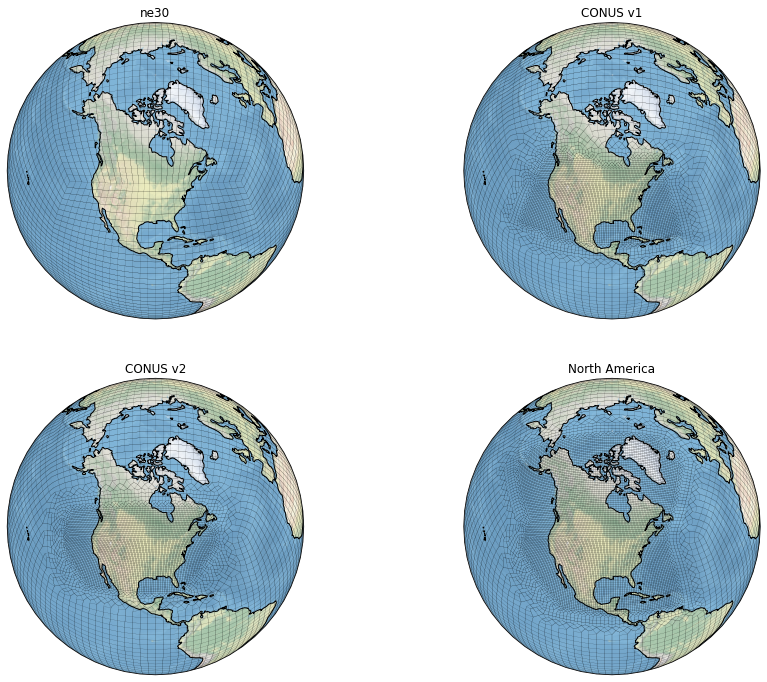

In [15]:
# Compare grids
this_conus = open_dataset(f'meshes/CONUS4v0.g') # Produced CONUS grid
conus = open_dataset('conusx4v1.g') # conus in E3SM init
na =open_dataset('northamericax4v1.g') # North America in E3SM init
figure = pyplot.figure(figsize=(15, 12))
i=1
for grid,t in zip([ne30, this_conus,conus,na],['ne30','CONUS v1', 'CONUS v2', 'North America']):
    ax = figure.add_subplot(220+i, projection=crs.Orthographic(central_latitude=50,central_longitude=-90))
    ax.stock_img()
    ax.coastlines()
    lines=get_lines(grid,ax)
    ax.set_title(t)
    i=i+1

In [21]:
# getting scrip files to create map files for ne30
!ConvertExodusToSCRIP --in meshes/ne30.g  --out meshes/ne30.scrip.nc

Parameters:
  --in <string> ["meshes/ne30.g"] 
  --out <string> ["meshes/ne30.scrip.nc"] 
  --out_format <string> ["netcdf4"] 
------------------------------------------------------------

..Loading input mesh
Mesh size: Nodes [5402] Elements [5400]
..Writing mesh
Nodes per element
..Block 1 (4 nodes): 5400
..Done writing
..Mesh converter exited successfully


In [22]:
# getting scrip files to create map files for CONUS
!ConvertExodusToSCRIP --in conusx4v1.g  --out meshes/conusx4v1.scrip.nc

Parameters:
  --in <string> ["conusx4v1.g"] 
  --out <string> ["meshes/conusx4v1.scrip.nc"] 
  --out_format <string> ["netcdf4"] 
------------------------------------------------------------

..Loading input mesh
Mesh size: Nodes [9907] Elements [9905]
..Writing mesh
Nodes per element
..Block 1 (4 nodes): 9905
..Done writing
..Mesh converter exited successfully


In [23]:
# creating map files (lat-lon to ne30) for random emis init file
!ncremap -a fv2se_flx --src_grd=grids/96x144_SCRIP.20160301.nc --dst_grd=meshes/ne30.scrip.nc -m map_fv2se.nc
!ncremap -m map_fv2se.nc ar5_mam3_so2_surf_2000_c120315.nc meshes/ar5_mam3_so2_surf_2000_c120315_se.nc

Grid(src): grids/96x144_SCRIP.20160301.nc
Grid(dst): meshes/ne30.scrip.nc
Input #00: /mnt/d/Work/Codes/ar5_mam3_so2_surf_2000_c120315.nc
Map/Wgt  : map_fv2se.nc


In [29]:
# Func to plot
def get_data(ds, variable_name):
    if variable_name in ds.variables.keys():
        data = ds[variable_name]
    elif variable_name == 'PRECT':
        precc = get_data(ds, 'PRECC')
        precl = get_data(ds, 'PRECL')
        data = precc + precl
        data.attrs = precc.attrs
        data.attrs['long_name'] = 'Total precipitation rate'
    else:
        raise NameError('%s not found in dataset'%variable_name)

    # Adjust units
    if variable_name in ('PRECC', 'PRECL', 'PRECT'):
        if data.attrs['units'].lower() == 'm/s':
            attrs = data.attrs
            data = 60 * 60 * 24 * 1e3 * data
            data.attrs = attrs
            data.attrs['units'] = 'mm/day'
    return data

def plot_map(lon, lat, data, lon_corners=None, lat_corners=None, method='contourf', **kwargs):

    # Fix longitudes
    from xarray import DataArray
    # new_lon = lon.copy(deep=True)
    # new_lon.values = np.where(lon > 180, lon - 360, lon)
    # new_lon = lon.assign_coords(lon=((lon + 180) % 360) - 180)
    
    diff=(data.max()-data.min())/16
    l=np.arange(data.min(),data.max(),diff)
    if sum(n < 0 for n in l)==0:
        sdiff=(l[1]-l[0])/4
        sl=np.arange(l[0],l[1],sdiff)
        l2=np.append(sl,l[1:])
        mdiff=(l[-1]-l[-2])/4
        ml=np.arange(l[-2],l[-1],mdiff)
        lev=np.append(l2[:-2],ml).tolist()
        c='YlOrRd'
        e='max'
    else:
        sdiff=(data.max()-0)/9
        sl=np.arange(0,data.max(),sdiff)
        ml=-1*sl
        lev=np.append(ml[::-1],sl[1:]).tolist()
        c='RdYlGn'
        e='both'
    lev=[0.0, 13991777.0, 27983554.0, 41975331.0, 55967108.0, 111934216.0, 167901324.0, 223868432.0, 279835540.0, 335802648.0, 391769756.0, 447736864.0, 503703972.0, 559671080.0, 615638188.0, 671605296.0, 727572404.0, 783539512.0, 797531289.0, 811523066.0, 825514843.0]
    # Setup plot axes
    ax = pyplot.gca()
    ax.set_global()
    ax.coastlines()

    # Make plot
    if all([v is not None for v in (lon_corners, lat_corners)]):
        pl = plot_map_native(lon_corners, lat_corners, data, **kwargs)
    elif 'ncol' in data.dims:
        new_lon = lon.copy(deep=True)
        new_lon.values = np.where(lon > 180, lon - 360, lon)
        # Drop missing data
        new_lon = new_lon.where(data.squeeze().notnull()).dropna('ncol')
        lat = lat.where(data.squeeze().notnull()).dropna('ncol')
        data = data.squeeze().dropna('ncol')

        # Plot
        if method == 'pcolor':
            pl = ax.tripcolor(new_lon.squeeze(), lat.squeeze(), data.squeeze(), **kwargs)
        elif method == 'contourf':
            pl = ax.tricontourf(new_lon.squeeze(), lat.squeeze(), data.squeeze(),levels=lev,cmap=c,extend=e, **kwargs)
        else:
            raise ValueError('%s not a valid plot method'%(method))
    else:
        new_lon = lon.assign_coords(lon=((lon + 180) % 360) - 180)
        # print(data.shape,lon.shape,lat.shape)
        new_lon=new_lon.round(1)
        data2, lon2 = add_cyclic_point(data.values, coord=new_lon,axis=1)
        if method == 'pcolor':
            pl = ax.pcolormesh(lon2, lat, data2, **kwargs)
        elif method == 'contourf':
            pl = ax.contourf(lon2, lat, data2, levels=lev,cmap=c,extend=e,**kwargs)
        else:
            raise ValueError('%s not a valid plot method'%(method))
    cb = pyplot.colorbar(
        pl, ax=axes, orientation='horizontal',
        label='%s (%s)'%(data.long_name, data.units),
        shrink=0.8, pad=0.02
    )

    # Return plot handle
    return pl

def plot_field(dataset, field, plot_type='map', **kwargs):

    # Get data
    data = get_data(dataset, field).mean(dim='time',keep_attrs=True)#[0,0]

    if plot_type == 'map':
        lon = get_data(dataset, 'lon')
        lat = get_data(dataset, 'lat')
        pl = plot_map(lon, lat, data, **kwargs)

    return pl

In [27]:
so2 = open_dataset('ar5_mam3_so2_surf_2000_c120315.nc')
so2se = open_dataset('meshes/ar5_mam3_so2_surf_2000_c120315_se.nc')

Text(0.5, 1.0, 'ne30/SE grid')

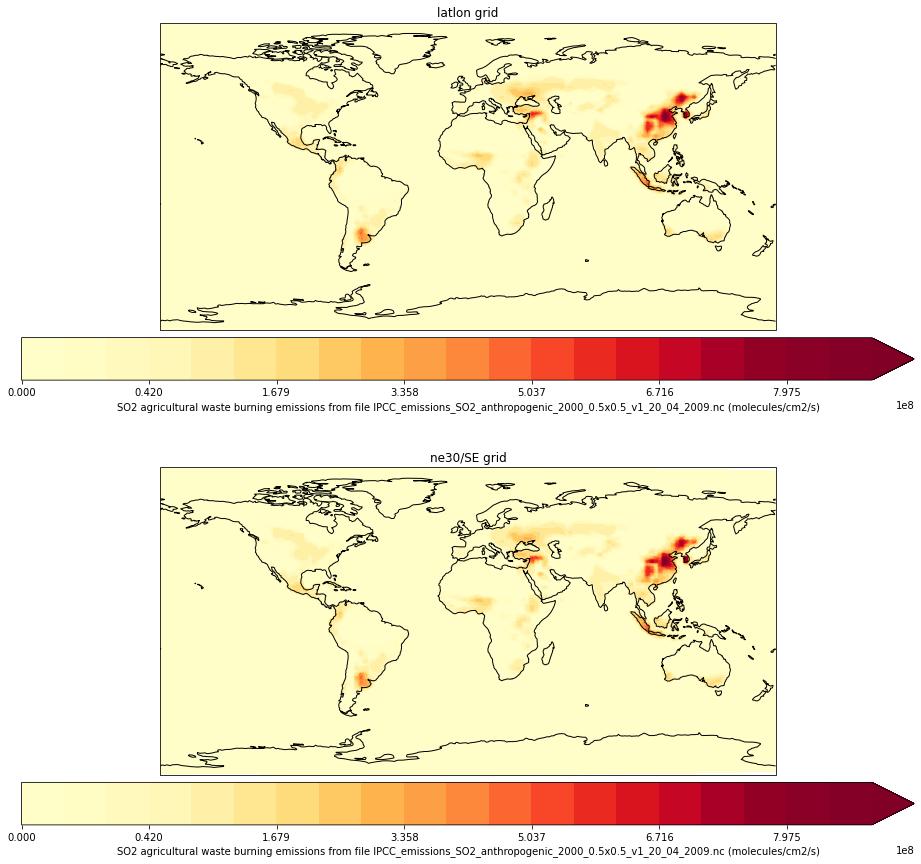

In [36]:
from cartopy.util import add_cyclic_point
figure = pyplot.figure(figsize=(20, 15))
axes = figure.add_subplot(211, projection=crs.PlateCarree())
plot_field(so2,'emiss_awb')
pyplot.title('latlon grid')

axes = figure.add_subplot(212, projection=crs.PlateCarree())
plot_field(so2se,'emiss_awb')
pyplot.title('ne30/SE grid')